In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_log_to_dataframe(filepath):
    """
    Load a log file to a dataframe.

    Log files are stored in json format. The log is a dict with labels as keys.
    Each entry is a list of pairs (score, solver_text), sorted by score. 
    A score of 1.1 indicates solver failed to compile to a program.
    A score of 1.0 (almost surely) indicates that solver_text compiled but failed to 
    run on one of the pairs or timed out.
    Any lower scores are aggregates of scoring functions, as per fitness_scoring.py.
    The solver texts should not include docstrings.

    The returned dataframe has rows indexed by labels, with each row simply a list
    of scores, i.e. we don't keep the solver texts around.
    """
    with open(filepath, 'r') as f:
        log = json.load(f)
        D = {label: [score for score, _ in log[label]] for label in log.keys()}
        return pd.DataFrame.from_dict(D, orient = 'index')

def compute_summary_stats(df):
    """
    Takes a log dataframe as generated by load_log_to_dataframe, and
    computes the following statistics for each row:
        min_fitness = best fitness of all fitnesses in row
        mean_fitness = mean of all fitnesses that are < 1
        compile_rate = percent of fitnesses <= 1
        score_rate = percent of fitnesses < 1
    """
    result = pd.DataFrame(df.min(axis = 1))
    result.columns = ['min_fitness']
    result['mean_fitness'] = df.apply(lambda x: x[x < 1].mean(), axis = 1)
    result['compile_rate'] = df.apply(lambda x: (x <= 1).sum()/len(x), axis = 1)
    result['score_rate'] = df.apply(lambda x: (x < 1).sum()/len(x), axis = 1)
    return result
        

In [3]:
# 400 solvers + 400 verifiers, run against every eval task training results.
baseline = load_log_to_dataframe("fitness data/baseline.json")
baseline_summary = compute_summary_stats(baseline)

### Experiment 3, 10/26/2024: How does top_k affect results?

Generated using:

<code>model = v5
top_ks = [2, 4, 8, 16, 32, 64, 128]
solvers_per_task = 512,
 generate_args = {
        'max_new_tokens': 512,
        'do_sample': True,
        'top_k': top_k,
        'temperature': 2.0,
 }<code>

 Runtime: A couple hours

 Quick observation: Basically very little changes as top_k varies. Perhaps a bit of improvement on our 'hard' task, and a bit lower scoring rate and compile rate (5% less more or less from one extreme to the other).

In [96]:
top_ks = [2, 4, 8, 16, 32, 64, 128]

In [97]:
top_k_results = {}
labels = ['d56f2372', '1e97544e', '3490cc26', 'bf699163', '2037f2c7']
for top_k in top_ks:
    top_k_results[top_k] = compute_summary_stats(load_log_to_dataframe(f'fitness data/top_k experiments/{top_k}.json'))

In [98]:
print("Baseline")
print(baseline_summary.loc[labels])
print(baseline_summary.loc[labels].mean(axis = 0))

Baseline
          min_fitness  mean_fitness  compile_rate  score_rate
d56f2372     0.000000      0.677624           1.0     0.73625
1e97544e     0.032765      0.244017           1.0     0.74750
3490cc26     0.081735      0.350067           1.0     0.72125
bf699163     0.160784      0.674017           1.0     0.77125
2037f2c7     0.394032      0.793639           1.0     0.72250
min_fitness     0.133863
mean_fitness    0.547873
compile_rate    1.000000
score_rate      0.739750
dtype: float64


In [99]:
for top_k in top_ks:
    print(f"top_k = {top_k}")
    print(top_k_results[top_k])
    print("")
    print("")

top_k = 2
          min_fitness  mean_fitness  compile_rate  score_rate
d56f2372     0.273996      0.610539      0.927734    0.693359
1e97544e     0.048393      0.222264      0.810547    0.572266
3490cc26     0.081735      0.250750      0.871094    0.634766
bf699163     0.160784      0.544837      0.777344    0.593750
2037f2c7     0.467617      0.738080      0.796875    0.550781


top_k = 4
          min_fitness  mean_fitness  compile_rate  score_rate
d56f2372     0.000000      0.613408      0.906250    0.625000
1e97544e     0.065556      0.210325      0.785156    0.466797
3490cc26     0.034681      0.263523      0.847656    0.550781
bf699163     0.160784      0.567278      0.767578    0.570312
2037f2c7     0.467617      0.731768      0.802734    0.505859


top_k = 8
          min_fitness  mean_fitness  compile_rate  score_rate
d56f2372     0.000000      0.614583      0.916016    0.613281
1e97544e     0.059784      0.204465      0.753906    0.447266
3490cc26     0.081735      0.240035 

### Experiment 2, 10/26/2024: How does number of solvers affect results?

Generated using:

<code>model = v5
solver_counts = [32, 64, 128, 256, 512, 1024, 2048]
solvers_per_task = solver_count,
generate_args = {
    'max_new_tokens': 512,
    'do_sample': True,
    'top_k': 50,
    'temperature': 2.0,
}<code>

Runtime approx 2 hours.

In [73]:
solver_counts = [32, 64, 128, 256, 512, 1024, 2048]

In [74]:
num_solvers_results = {}
labels = ['d56f2372', '1e97544e', '3490cc26', 'bf699163', '2037f2c7']
for count in solver_counts:
    num_solvers_results[count] = compute_summary_stats(load_log_to_dataframe(f'fitness data/num_solvers experiments/{count}.json'))

In [75]:
print("Baseline")
print(baseline_summary.loc[labels])
print(baseline_summary.loc[labels].mean(axis = 0))

Baseline
          min_fitness  mean_fitness  compile_rate  score_rate
d56f2372     0.000000      0.677624           1.0     0.73625
1e97544e     0.032765      0.244017           1.0     0.74750
3490cc26     0.081735      0.350067           1.0     0.72125
bf699163     0.160784      0.674017           1.0     0.77125
2037f2c7     0.394032      0.793639           1.0     0.72250
min_fitness     0.133863
mean_fitness    0.547873
compile_rate    1.000000
score_rate      0.739750
dtype: float64


In [76]:
for c in solver_counts:
    print(f"num_solvers = {c}")
    print(num_solvers_results[c])
    print("")
    print("")

num_solvers = 32
          min_fitness  mean_fitness  compile_rate  score_rate
d56f2372     0.370006      0.621321       0.96875     0.65625
1e97544e     0.065556      0.275378       0.81250     0.43750
3490cc26     0.081735      0.288741       0.65625     0.50000
bf699163     0.298148      0.473050       0.78125     0.56250
2037f2c7     0.512466      0.686967       0.90625     0.37500


num_solvers = 64
          min_fitness  mean_fitness  compile_rate  score_rate
d56f2372     0.290375      0.583200      0.875000    0.562500
1e97544e     0.032765      0.246786      0.687500    0.421875
3490cc26     0.081735      0.259070      0.843750    0.578125
bf699163     0.160784      0.550549      0.687500    0.453125
2037f2c7     0.508309      0.763462      0.703125    0.312500


num_solvers = 128
          min_fitness  mean_fitness  compile_rate  score_rate
d56f2372     0.274348      0.616408      0.914062    0.601562
1e97544e     0.065556      0.221252      0.710938    0.500000
3490cc26     0

In [84]:
min_fitnesses = pd.concat([num_solvers_results[c]['min_fitness'] for c in solver_counts], axis = 1)
min_fitnesses.columns = solver_counts
min_fitnesses = min_fitnesses.transpose()
min_fitnesses = min_fitnesses.reset_index(names = 'num_solvers')
min_fitnesses

,num_solvers,d56f2372,1e97544e,3490cc26,bf699163,2037f2c7
0,32,0.370006,0.065556,0.081735,0.298148,0.512466
1,64,0.290375,0.032765,0.081735,0.160784,0.508309
2,128,0.274348,0.065556,0.081735,0.160784,0.518050
3,256,0.000000,0.065556,0.081735,0.160784,0.465616
4,512,0.267648,0.048393,0.081735,0.160784,0.430442
5,1024,0.000000,0.048393,0.081735,0.160784,0.315485
6,2048,0.000000,0.048393,0.081735,0.160784,0.297312


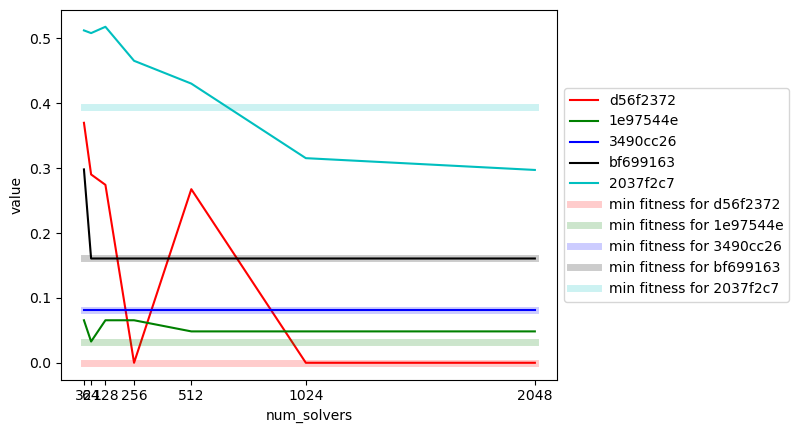

In [94]:
palette = ['r', 'g', 'b', 'k', 'c']
ax = sns.lineplot(data = pd.melt(min_fitnesses, 'num_solvers'),
                  x = 'num_solvers',
                  y = 'value',
                  hue = 'variable',
                  palette = palette,
                 )
for i, l in enumerate(labels):
    v = baseline_summary.loc[l, 'min_fitness']
    ax.plot([solver_counts[0], solver_counts[-1]],
            [v, v],
            f"{palette[i]}",
            label = f"min fitness for {l}",
            alpha = 0.2,
            linewidth = 5,
           )
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(solver_counts)
plt.show()

### Experiment 1, 10/25/2024: How does temperature affect results?

Generated using:

<code>model = v5
temps = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
solvers_per_task = 256,
generate_args = {
    'max_new_tokens': 512,
    'do_sample': True,
    'top_k': 50,
    'temperature': temp,
}<code>

Runtime approx 90 minutes.

In [16]:
temp_results = {}
temps = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
labels = ['d56f2372', '1e97544e', '3490cc26', 'bf699163', '2037f2c7']
for temp in temps:
    temp_results[temp] = compute_summary_stats(load_log_to_dataframe(f'fitness data/temperature experiments/temp{temp}.json'))

In [15]:
print("Baseline")
print(baseline_summary.loc[labels])
print(baseline_summary.loc[labels].mean(axis = 0))

Baseline
          min_fitness  mean_fitness  compile_rate  score_rate
d56f2372     0.000000      0.677624           1.0     0.73625
1e97544e     0.032765      0.244017           1.0     0.74750
3490cc26     0.081735      0.350067           1.0     0.72125
bf699163     0.160784      0.674017           1.0     0.77125
2037f2c7     0.394032      0.793639           1.0     0.72250
min_fitness     0.133863
mean_fitness    0.547873
compile_rate    1.000000
score_rate      0.739750
dtype: float64


In [11]:
for temp in temps:
    print(f"Temperature = {temp}")
    print(temp_results[temp])
    print("")
    print("")

Temperature = 0.5
          min_fitness  mean_fitness  compile_rate  score_rate
d56f2372     0.266349      0.605779      0.933594    0.750000
1e97544e     0.064729      0.202321      0.769531    0.582031
3490cc26     0.034681      0.283048      0.855469    0.679688
bf699163     0.160784      0.534370      0.824219    0.640625
2037f2c7     0.467617      0.745489      0.785156    0.578125


Temperature = 1.0
          min_fitness  mean_fitness  compile_rate  score_rate
d56f2372     0.267648      0.612393      0.945312    0.738281
1e97544e     0.065556      0.217339      0.820312    0.558594
3490cc26     0.081735      0.237800      0.886719    0.714844
bf699163     0.160784      0.541569      0.746094    0.562500
2037f2c7     0.430442      0.735255      0.816406    0.628906


Temperature = 1.5
          min_fitness  mean_fitness  compile_rate  score_rate
d56f2372     0.274348      0.619580      0.933594    0.710938
1e97544e     0.057456      0.202928      0.781250    0.531250
3490cc26    

In [67]:
# Aside: We were able to recover solution for d56f2372 when temp = 3.0, let's look at it
with open('fitness data/temperature experiments/temp3.0.json', 'r') as f:
    log3 = json.load(f)

In [71]:
# This is regurgitating the verifier solve_72ca375d. 
print(log3['d56f2372'][0][1])

def solve_82178ed4(I):
    x1 = objects(I, T, T, T)
    x2 = fork(equality, identity, vmirror)
    x3 = extract(x1, x2)
    O = subgrid(x3, I)
    return O


In [25]:
means_by_temp = pd.concat([pd.DataFrame(temp_results[temp].mean(axis = 0)) for temp in temps], axis = 1)
means_by_temp.columns = temps
means_by_temp = means_by_temp.transpose()
means_by_temp['temperature'] = means_by_temp.index

In [26]:
means_by_temp

,min_fitness,mean_fitness,compile_rate,score_rate,temperature
0.5,0.198832,0.474201,0.833594,0.646094,0.5
1.0,0.201233,0.468871,0.842969,0.640625,1.0
1.5,0.209528,0.472580,0.828906,0.597656,1.5
2.0,0.207099,0.477888,0.766406,0.467187,2.0
2.5,0.203450,0.472659,0.643750,0.367188,2.5
3.0,0.166646,0.458062,0.445312,0.182812,3.0
3.5,0.257168,0.460523,0.247656,0.082812,3.5
4.0,0.257677,0.449170,0.135156,0.031250,4.0
4.5,0.401518,0.506155,0.059375,0.010156,4.5
5.0,0.775755,0.627729,0.025000,0.003125,5.0


In [52]:
baseline_avgs = pd.DataFrame(baseline_summary.loc[labels].mean(axis = 0)).transpose()
baseline_avgs

,min_fitness,mean_fitness,compile_rate,score_rate
0,0.133863,0.547873,1.0,0.73975


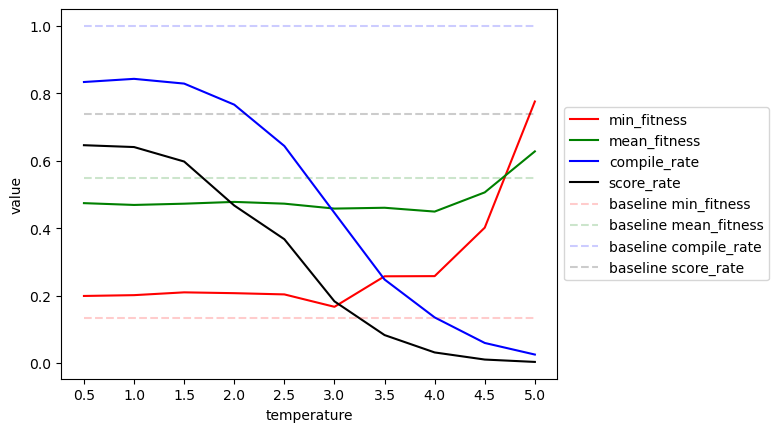

In [66]:
palette = ['r', 'g', 'b', 'k']
ax = sns.lineplot(data = pd.melt(means_by_temp, 'temperature'),
                  x = 'temperature',
                  y = 'value',
                  hue = 'variable',
                  palette = palette,
                 )
for i, var in enumerate(['min_fitness', 'mean_fitness', 'compile_rate', 'score_rate']):
    ax.plot([temps[0], temps[-1]],
            [baseline_avgs[var],baseline_avgs[var]],
            f"{palette[i]}--",
            label = f"baseline {var}",
            alpha = 0.2,
           )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(temps)
plt.show()

### First few runs stats and analysis

In [35]:
# First shot at generating solvers from v3 model. Not sure of hyperparameters.
# solvers_per_task = 50
v3 = load_log_to_dataframe("fitness data/v3.json")
v3_summary = compute_summary_stats(v3)

# temp = 3,
# top_k = 3,
# solvers per task = 200,
# model = v4,
# max_new_tokens = 512,
# max batchsize = ?
# quantization = None
# 
# RUNTIME: ?
v4 = load_log_to_dataframe("fitness data/v4.json")
v4_summary = compute_summary_stats(v4)

# temp = 2
# top_k = 10
# solvers per task = 1000,
# model = v5,
# max_new_tokens = 512,
# Max batchsize = 32
# quantization = None
#
# RUNTIME: ?
# NOTES: Only 60 tasks, crashed and burned
v5_partial = load_log_to_dataframe("fitness data/v5_partial.json")
v5_partial_summary = compute_summary_stats(v5_partial)

# temp = 2,
# top_k = 50,
# solvers per task = 200,
# model = v5,
# max_new_tokens = 512,
# Max batchsize = 16 (32 gave OOM on 25094a63, task at index 60, requires 900+ tokens for prompts)
# quantization = None
#
# RUNTIME: ~10 hours?
# NOTES: Much better compile and score rate (85%, 53% respectively) compared
# to previous models. That said, does not *really* improve on baseline 
# much at all. Only improves 21 scores, and recovers 150 exactly. Rest are usually worse by 0.05ish.
v5 = load_log_to_dataframe("fitness data/v5.json")
v5_summary = compute_summary_stats(v5)

In [13]:
D = v3.min(axis = 1)

In [26]:
compute_summary_stats(baseline).mean(axis = 0)

min_fitness     0.107550
mean_fitness    0.393638
compile_rate    1.000000
score_rate      0.743159
dtype: float64

In [27]:
compute_summary_stats(v3).mean(axis = 0)

min_fitness     0.182848
mean_fitness    0.374479
compile_rate    0.714700
score_rate      0.265750
dtype: float64

In [28]:
compute_summary_stats(v4).mean(axis = 0)

min_fitness     0.150553
mean_fitness    0.343108
compile_rate    0.732900
score_rate      0.259750
dtype: float64

In [29]:
compute_summary_stats(v5_partial).mean(axis = 0)

min_fitness     0.126216
mean_fitness    0.347584
compile_rate    0.870350
score_rate      0.549200
dtype: float64

In [30]:
compute_summary_stats(v5).mean(axis = 0)

min_fitness     0.140273
mean_fitness    0.342331
compile_rate    0.842288
score_rate      0.534650
dtype: float64

In [31]:
v5_summary = compute_summary_stats(v5)

In [34]:
v5_summary.sort_values(by = 'score_rate')

,min_fitness,mean_fitness,compile_rate,score_rate
d4b1c2b1,0.196241,0.296834,0.785,0.295
ca8f78db,0.009400,0.240156,0.665,0.340
981571dc,0.011439,0.186709,0.685,0.340
11e1fe23,0.052334,0.192510,0.905,0.350
50a16a69,0.143633,0.320920,0.780,0.355
...,...,...,...,...
e133d23d,0.300243,0.494298,0.935,0.705
8597cfd7,0.212500,0.528692,0.910,0.705
34b99a2b,0.203384,0.525609,0.895,0.710
68b67ca3,0.000000,0.403582,0.930,0.720


In [36]:
baseline_summary.sort_values(by = 'score_rate')

,min_fitness,mean_fitness,compile_rate,score_rate
d4b1c2b1,0.176578,0.274914,1.0,0.53500
332efdb3,0.129565,0.492515,1.0,0.55625
695367ec,0.515877,0.810080,1.0,0.56500
e619ca6e,0.043300,0.311997,1.0,0.65250
ba9d41b8,0.040109,0.313746,1.0,0.65500
...,...,...,...,...
af24b4cc,0.302874,0.524817,1.0,0.82500
506d28a5,0.000000,0.505070,1.0,0.82625
be03b35f,0.207143,0.477583,1.0,0.82625
cfb2ce5a,0.111956,0.304898,1.0,0.82875


In [40]:
v5_summary[v5_summary['min_fitness'] == 0]

,min_fitness,mean_fitness,compile_rate,score_rate
60c09cac,0.0,0.402688,0.905,0.560
0c9aba6e,0.0,0.514198,0.880,0.620
68b67ca3,0.0,0.403582,0.930,0.720
27f8ce4f,0.0,0.456413,0.870,0.535
cd3c21df,0.0,0.503749,0.845,0.575
c663677b,0.0,0.209678,0.745,0.465
e95e3d8e,0.0,0.219117,0.710,0.380
ea9794b1,0.0,0.454547,0.835,0.565
ea959feb,0.0,0.158835,0.725,0.365
e345f17b,0.0,0.538346,0.855,0.625


In [42]:
print((v5_summary['min_fitness'] == 0).sum())

10


In [43]:
print((v4_summary['min_fitness'] == 0).sum())

6


In [44]:
print((v5_partial_summary['min_fitness'] == 0).sum())

2


In [53]:
v5_diffs = v5_summary.sort_index()['min_fitness'] -baseline_summary.sort_index()['min_fitness']
v5_diffs = v5_diffs.sort_values()
v5_diffs

e345f17b   -0.204511
9110e3c5   -0.127925
e6de6e8f   -0.077972
e0fb7511   -0.045452
31adaf00   -0.041569
              ...   
4c177718    0.311734
e1baa8a4    0.326293
f4081712    0.326857
67b4a34d    0.328428
73182012    0.340567
Name: min_fitness, Length: 400, dtype: float64

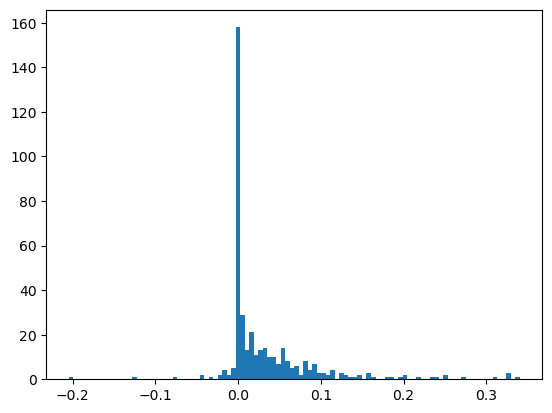

In [56]:
plt.hist(v5_diffs, bins = 100)
plt.show()

In [57]:
(v5_diffs < 0).sum()

27

In [58]:
(v5_diffs == 0).sum()

121

In [73]:
baseline_summary.iloc[:16]

,min_fitness,mean_fitness,compile_rate,score_rate
c663677b,0.0,0.269272,1.0,0.72375
e95e3d8e,0.0,0.263356,1.0,0.70750
60c09cac,0.0,0.442769,1.0,0.78500
73182012,0.0,0.521128,1.0,0.78125
9ddd00f0,0.0,0.254266,1.0,0.73750
cd3c21df,0.0,0.646198,1.0,0.75750
67b4a34d,0.0,0.624385,1.0,0.75125
f4081712,0.0,0.705100,1.0,0.70000
070dd51e,0.0,0.326098,1.0,0.71375
ca8f78db,0.0,0.265750,1.0,0.71250


In [66]:
baseline_summary.iloc[95:105]

,min_fitness,mean_fitness,compile_rate,score_rate
1e97544e,0.032765,0.244017,1.0,0.74750
e88171ec,0.033819,0.301085,1.0,0.66500
5b692c0f,0.034053,0.281695,1.0,0.73625
f83cb3f6,0.034074,0.358916,1.0,0.72750
85b81ff1,0.034690,0.266769,1.0,0.74625
9bebae7a,0.035785,0.358915,1.0,0.75625
0d87d2a6,0.035863,0.300045,1.0,0.74500
df8cc377,0.037153,0.334218,1.0,0.73125
aa300dc3,0.037927,0.277703,1.0,0.75500
17b80ad2,0.038034,0.293606,1.0,0.68750


In [68]:
baseline_summary.iloc[195:205]

,min_fitness,mean_fitness,compile_rate,score_rate
b7fb29bc,0.081094,0.388504,1.0,0.72625
3490cc26,0.081735,0.350067,1.0,0.72125
1c02dbbe,0.081860,0.312643,1.0,0.76125
ad7e01d0,0.081915,0.572235,1.0,0.74000
c074846d,0.082068,0.319818,1.0,0.78625
212895b5,0.082333,0.374969,1.0,0.72625
dd2401ed,0.082960,0.361283,1.0,0.79875
4c177718,0.082975,0.528768,1.0,0.79375
4b6b68e5,0.083186,0.322134,1.0,0.73375
cb227835,0.083484,0.365385,1.0,0.73375


In [69]:
baseline_summary.iloc[295:105]

,min_fitness,mean_fitness,compile_rate,score_rate
5207a7b5,0.152233,0.358838,1.0,0.73250
a934301b,0.152868,0.379926,1.0,0.76125
84db8fc4,0.154185,0.341381,1.0,0.77625
6ad5bdfd,0.155569,0.360242,1.0,0.79250
0692e18c,0.155662,0.528353,1.0,0.73000
b7cb93ac,0.156230,0.543867,1.0,0.77250
a59b95c0,0.157797,0.339623,1.0,0.69875
3391f8c0,0.159181,0.351005,1.0,0.70625
351d6448,0.160709,0.551540,1.0,0.76000
bf699163,0.160784,0.674017,1.0,0.77125


In [70]:
baseline_summary.iloc[390:]

,min_fitness,mean_fitness,compile_rate,score_rate
9110e3c5,0.344246,0.586741,1.0,0.75875
0a1d4ef5,0.353827,0.815061,1.0,0.73625
c3202e5a,0.355907,0.787963,1.0,0.77125
c64f1187,0.371293,0.590137,1.0,0.75375
2037f2c7,0.394032,0.793639,1.0,0.72250
1a6449f1,0.396403,0.642799,1.0,0.75125
e6de6e8f,0.399067,0.541711,1.0,0.74750
aab50785,0.406226,0.587357,1.0,0.76375
b4a43f3b,0.432686,0.658681,1.0,0.80000
695367ec,0.515877,0.810080,1.0,0.56500


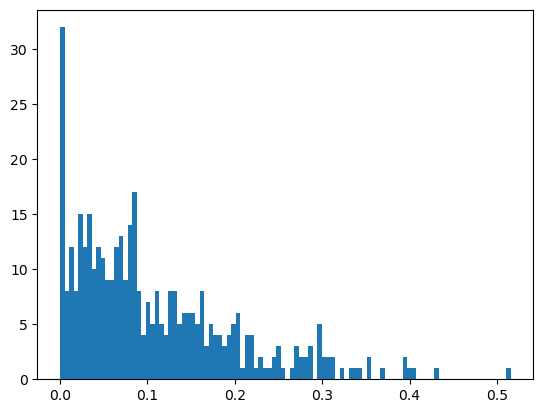

In [72]:
plt.hist(baseline_summary['min_fitness'], bins = 100)
plt.show()

# OLD BELOW HERE

In [43]:
with open("fitness data/baseline_solvers_vs_eval.json", "r") as f:
    baseline_fitnesses = json.load(f)
with open("fitness data/first_pass_v3_generation.json", "r") as f:
    first_pass = json.load(f) # 
with open("fitness data/v4_solvers_vs_eval.json", "r") as f:
    # temp = 3,
    # top_k = 3,
    # solvers per task = 200,
    # model = v4,
    # max_new_tokens = 512,
    # max batchsize = ?
    # quantization = None
    #
    # RUNTIME: ?
    # NOTES: Seems like typically 75% valid programs, 25% valid scores
    v4 = json.load(f) 
with open("fitness data/v5???", "r") as f:
    # temp = 2,
    # top_k = 50,
    # solvers per task = 200,
    # model = v5,
    # max_new_tokens = 512,
    # Max batchsize = 16 (32 gave OOM on 25094a63, task at index 60, requires 900+ tokens for prompts)
    # quantization = None
    #
    # RUNTIME: ~10 hours?
    # NOTES: 
    pass

In [44]:
task_labels = [entry[0] for entry in baseline_fitnesses]

In [45]:
baseline_fitnesses[0][1][0][1]

0.0

In [46]:
D = {label: [] for label in task_labels}
for entry in baseline_fitnesses:
    D[entry[0]].append(entry[1][0][1])
for entry in first_pass:
    D[entry[0]].append(entry[1][0][1])
for entry in v4:
    D[entry[0]].append(entry[1][0][1])

In [48]:
best_fitnesses = pd.DataFrame.from_dict(D, orient = 'index')
best_fitnesses.columns = ['baseline', 'v3', 'v4']

In [52]:
best_fitnesses['diff_v3'] = best_fitnesses['baseline'] - best_fitnesses['v3']
best_fitnesses['diff_v4'] = best_fitnesses['baseline'] - best_fitnesses['v4']

In [55]:
best_fitnesses[best_fitnesses['diff_v3'] > 0]

,baseline,v3,v4,diff_v3,diff_v4
14754a24,0.024656,0.018082,0.057700,0.006574,-0.033044
60a26a3e,0.040102,0.025890,0.042362,0.014212,-0.002260
0607ce86,0.041696,0.039960,0.045311,0.001736,-0.003615
32e9702f,0.066230,0.039890,0.126782,0.026340,-0.060553
12997ef3,0.285579,0.250851,0.360385,0.034728,-0.074806
1a6449f1,0.396403,0.367245,0.436520,0.029158,-0.040116


**Abysmal!** Only six were improved by first pass. However, we only generated 50 solvers per task from CodeGen

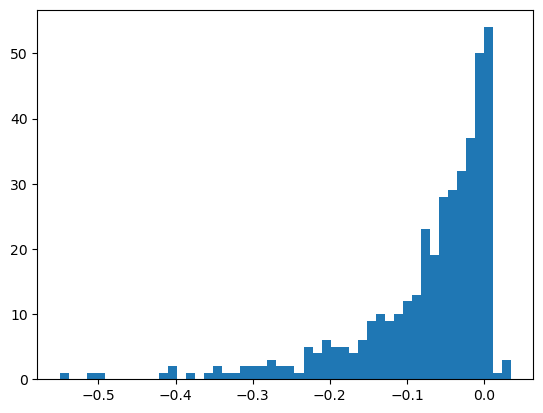

In [56]:
plt.hist(best_fitnesses['diff_v3'], bins = 50)
plt.show()

Mostly the first pass doesn't get too much worse

In [58]:
sum(best_fitnesses['diff_v3'] == 0)

50

For 50 tasks, we exactly matched the baseline

In [59]:
best_fitnesses.head(35)

,baseline,v3,v4,diff_v3,diff_v4
c663677b,0.000000,0.075285,0.075285,-0.075285,-0.075285
e95e3d8e,0.000000,0.079552,0.079552,-0.079552,-0.079552
60c09cac,0.000000,0.302237,0.000000,-0.302237,0.000000
73182012,0.000000,0.399941,0.000000,-0.399941,0.000000
9ddd00f0,0.000000,0.080540,0.080540,-0.080540,-0.080540
cd3c21df,0.000000,0.291996,0.000000,-0.291996,0.000000
67b4a34d,0.000000,0.353476,0.331709,-0.353476,-0.331709
f4081712,0.000000,0.407452,0.400000,-0.407452,-0.400000
070dd51e,0.000000,0.027177,0.001980,-0.027177,-0.001980
ca8f78db,0.000000,0.004228,0.069882,-0.004228,-0.069882


Concerningly, diff is big even for tasks where a verifier or solver gets fitness 0

In [60]:
for i in range(35):
    print(baseline_fitnesses[i][0], baseline_fitnesses[i][1][:3])

c663677b [['solve_0dfd9992', 0.0], ['solve_29ec7d0e', 0.0], ['solve_484b58aa', 0.0]]
e95e3d8e [['solve_0dfd9992', 0.0], ['solve_29ec7d0e', 0.0], ['solve_484b58aa', 0.0]]
60c09cac [['solve_b91ae062', 0.0], ['solve_c59eb873', 0.0], ['verify_b91ae062', 0.0]]
73182012 [['solve_2013d3e2', 0.0], ['solve_90c28cc7', 0.0], ['verify_2013d3e2', 0.0]]
9ddd00f0 [['solve_9d9215db', 0.0], ['solve_b8825c91', 0.0], ['verify_b8825c91', 0.0]]
cd3c21df [['solve_ce602527', 0.0], ['verify_0b148d64', 0.0], ['verify_1f85a75f', 0.0]]
67b4a34d [['solve_dc0a314f', 0.0], ['verify_dc0a314f', 0.0], ['verify_ff805c23', 0.0]]
f4081712 [['solve_dc0a314f', 0.0], ['verify_dc0a314f', 0.0], ['verify_ff805c23', 0.0]]
070dd51e [['solve_40853293', 0.0], ['verify_40853293', 0.0], ['solve_1f876c06', 0.0019801980198019802]]
ca8f78db [['solve_0dfd9992', 0.0], ['solve_29ec7d0e', 0.0], ['solve_3345333e', 0.004228097236670613]]
7039b2d7 [['verify_780d0b14', 0.0], ['verify_9f236235', 0.0], ['solve_1190e5a7', 0.03580246913580246]]
c7

The following all have verifiers but not solvers that beat them!

`7039b2d7`, `e66aafb8`, `47996f11`, `981571dc`, `af22c60d`, `ea959feb`, `e1baa8a4`, `50a16a69`, `506d28a5`, `aa18de87`, `5b6cbef5`, `68b67ca3`, `e7a25a18`, `0c9aba6e`

# V4 diffs




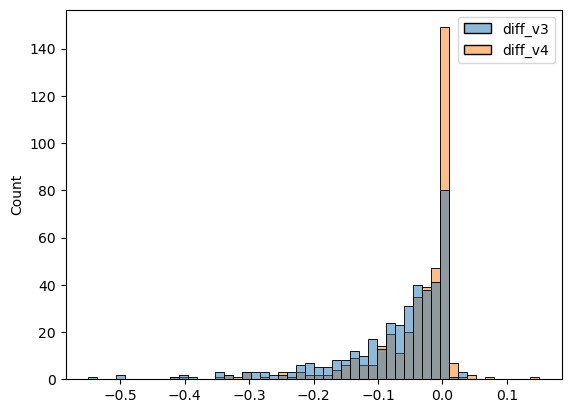

In [75]:
# TODO: Labeling
sns.histplot(best_fitnesses[['diff_v3', 'diff_v4']], bins = 50)
#plt.legend()
plt.show()

In [71]:
sum(best_fitnesses['diff_v4'] == 0)

100

In [72]:
sum(best_fitnesses['v4'] == 0)

6

In [73]:
sum(best_fitnesses['diff_v4'] > best_fitnesses['diff_v3'])

224

In [74]:
min(best_fitnesses['diff_v4'])

-0.4187203609707148

In [76]:
best_fitnesses[best_fitnesses['v4'] == 0]

,baseline,v3,v4,diff_v3,diff_v4
60c09cac,0.0,0.302237,0.0,-0.302237,0.0
73182012,0.0,0.399941,0.0,-0.399941,0.0
cd3c21df,0.0,0.291996,0.0,-0.291996,0.0
27f8ce4f,0.0,0.241102,0.0,-0.241102,0.0
ea959feb,0.0,0.036457,0.0,-0.036457,0.0
5b6cbef5,0.0,0.505049,0.0,-0.505049,0.0
